<a href="https://colab.research.google.com/github/pwatana/CAUserLogin/blob/main/Copy_of_Neurotech_data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Condensed Step-by-Step Process with Relevant `scipy` imports

1. **Drift Removal**  
   - **Process:** Remove channel drift using a moving average filter. \\
     from scipy.signal import lfilter


2. **Bandpass Filter (1-30 Hz)**  
   - **Process:** Apply a bandpass FIR filter to remove very slow and fast fluctuations.
     \\ from scipy.signal import firwin, filtfilt

3. **Segmentation with Overlapping Windows**  
   - **Process:** Segment data using 3-second overlapping Hamming windows with 90% overlap.
     \\ from scipy.signal import hamming

4. **Autoregressive (AR) Spectrum Estimation**  
   - **Process:** Use a sixth-degree autoregressive model to calculate the frequency spectrum.
     \\ from spectrum import aryule ???

5. **Peak Power and Tremor Detection**  
   - **Process:** Find peaks in the frequency spectrum within the 3–8 Hz range and label tremor windows.
     \\ from scipy.signal import find_peaks

6. **Threshold Filtering for Low-Amplitude Vibrations**  
   - **Process:** Keep tremor-labeled windows with a peak frequency > T.

7. **Upsample Results**  
   - **Process:** Match the length of original accelerometer data by upsampling.
     \\ from scipy.signal import resample

8. **Smoothing to Eliminate Transient Perturbations**  
   - **Process:** Smooth the upsampled data.
     \\ from scipy.ndimage import gaussian_filter1d

9. **Combine Axes (X, Y, Z)**  
   - **Process:** Multiply the results of the three axes to preserve tremor information.



# Kristin - Accelerometer

In [1]:
!pip install mne
!pip install spectrum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.3/718.3 kB 23.2 MB/s eta 0:00:00
  Created wheel for spectrum: filename=spectrum-0.9.0-cp310-cp310-linux_x86_64.whl size=236747 sha256=3a2b4cd00a482324abd7513c2998d7e35db9f9bc97a6033226be9fe27cd52fa8
  Stored in directory: /root/.cache/pip/wheels/37/80/7f/0ff12dca2c4c50e04bfc9d9931a0059362a690d5ebaf9bbbd7
Successfully built spectrum


In [2]:
# imports
import os
import mne
import pickle
import scipy
import numpy as np

from spectrum import aryule, arma2psd
from scipy import signal
from scipy.signal import find_peaks
from scipy.signal.windows import hamming
from scipy.signal import find_peaks, firwin
from scipy.signal import lfilter
import matplotlib.pyplot as plt

In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# import data of single trial
# data imported as numpy array of shape (num_axis,num_timesteps) = (3,93501)

accelerometer_file_path = '/content/drive/My Drive/NeuroTechUofT24/accelerometer_data/801_1_accelerometer.pkl'
with open(accelerometer_file_path, 'rb') as f:
    accelerometer_data = pickle.load(f)

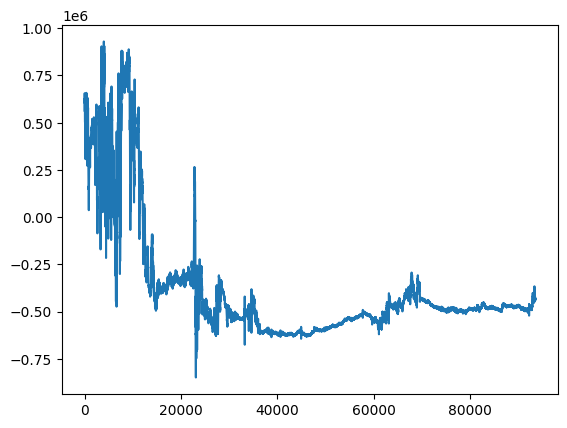

In [ ]:
# visualize accelerometer data for one axis

x = list(range(len(accelerometer_data[0])))
plt.plot(x, accelerometer_data[0])

In [ ]:
# create functions for steps 1 to 3

#1
def moving_average_filter(data, window_size):
  b = np.ones(window_size) / window_size
  a = [1]
  return lfilter(b, a, data)

# 2
def bandpass_filter(data, lowcut, highcut, fs, numtaps=101):
    taps = firwin(numtaps, [lowcut, highcut], pass_zero=False, fs=fs)
    filtered_data = lfilter(taps, 1.0, data)
    return filtered_data

#3
def segment_data(data, fs, overlap):

  window_size = int(3 * fs)
  step_size = int(window_size * (1 - overlap))
  num_windows = (len(data) - window_size) // step_size + 1
  hamming_window = hamming(window_size)
  segments = np.array([data[i:i + window_size] * hamming_window for i in range(0, len(data) - window_size + 1, step_size)])

  return segments

In [ ]:
# apply filters and segmentation to each axis in data
# store transfored data into a numpy array

acc_data = []
for axis in accelerometer_data:

  axis = moving_average_filter(axis, window_size = 100)
  axis = bandpass_filter(axis, lowcut=1, highcut=30, fs=500, numtaps=101)
  axis = segment_data(axis, fs = 500, overlap=0.9)
  acc_data.append(axis)

acc_data = np.array(acc_data)

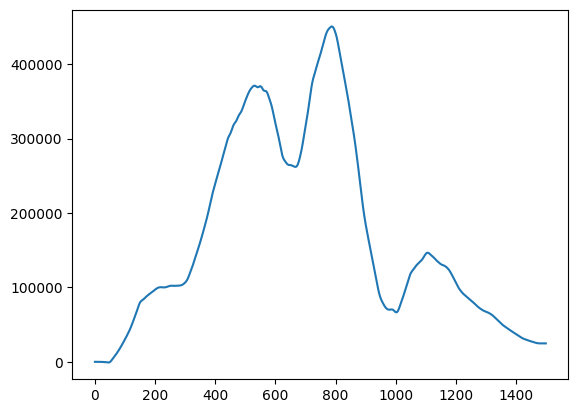

In [ ]:
# plot sample window
x = list(range(1500))
plt.plot(x, acc_data[0][0])

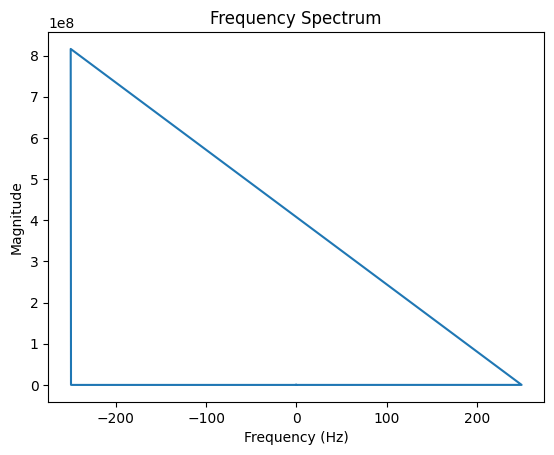

In [ ]:
# plot frequency spectrum for sample window
window = acc_data[1][3]


# create frequency spectrum
ar_coeffs,_,_ = aryule(window, 6)
psd = arma2psd(ar_coeffs, NFFT = len(window), sides = 'centerdc') # y-values
freq = np.fft.fftfreq(len(psd), d=1/500) # x-values

# plot spectrum
plt.plot(freq, psd)
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

In [ ]:
#4
def label(window, sampling_frequency = 500, tremor_min_freq = 3, tremor_max_freq = 8, ar_order = 6):

  labelled_windows = []

  # create frequency spectrum
  ar_coeffs,_,_ = aryule(window, ar_order)
  psd = arma2psd(ar_coeffs, NFFT = len(window)) # y-values
  psd = np.abs(psd)
  freq = np.fft.fftfreq(window.shape[0], d=1/sampling_frequency) # x-values


  # locate index of tallest peak
  peak_idx,_ = find_peaks(psd) # index of all peaks
  peak_heights = psd[peak_idx] # height of all peaks

  if len(peak_idx) == 0:
    return [1]

  tallest_peak_index = np.argmax(peak_heights)
  tallest_peak_freq = freq[tallest_peak_index] # frequency corresponding to tallest peak

  # compute threshhold
  T = peak_heights[tallest_peak_index] / 10

  # append window-label pair to list
  if (3 <= tallest_peak_freq <= 8) and (T):
    label = 0
    labelled_windows.append((window,label))
  else:
    label = 1
    labelled_windows.append((window,label))

  return labelled_windows

In [ ]:
#5
def dominant_peaks(window, sampling_frequency = 500, tremor_min_freq = 3, tremor_max_freq = 8, ar_order = 6):

  # create frequency spectrum
  ar_coeffs, _, _ = aryule(window, 6)
  psd = arma2psd(ar_coeffs, NFFT=len(window), sides='centerdc') # y-values
  psd = np.abs(psd)
  freq = np.fft.fftfreq(window.shape[0], d=1/sampling_frequency) # x-values


  # locate index of tallest peak
  peak_idx,_ = find_peaks(psd) # index of all peaks
  peak_heights = psd[peak_idx] # height of all peaks


  tallest_peak_index = np.argmax(peak_heights)
  tallest_peak_freq = freq[tallest_peak_index] # frequency corresponding to tallest peak


  # compute threshhold
  T = peak_heights[tallest_peak_index] / 10

  # obtain dominant peak
  if (3 <= tallest_peak_freq <= 8):
    dominant_peak = tallest_peak_freq
  else:
    dominant_peak = 1

  return dominant_peak

In [ ]:
for axis in acc_data:
  axis_peaks = [] # stores dominant peaks of all axis
  for window in axis:
    window_peaks = [] # stores dominant peak of each window in axis
    peaks = dominant_peaks(window)
    window_peaks.append(peaks)
    print(window_peaks)
  axis_peaks.append(window_peaks)

# Kristin - EEG

In [ ]:
# access eeg data for one trial
eeg_file_path = '/content/drive/My Drive/Neurotech UofT/eeg_data/801_2_PD_REST-epo.fif'

# load the data
raw = mne.io.read_raw_fif(eeg_file_path, preload=True)

In [ ]:
raw.compute_psd().plot()

In [ ]:
raw.plot(duration=5, proj=False, n_channels=len(raw.ch_names), remove_dc=False)

In [ ]:
# bandpass filtering
raw.filter(l_freq=1.0, h_freq=40.0)

In [ ]:
raw.plot(n_channels=10, duration=5, remove_dc = True, scalings='auto')

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 20.6s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated


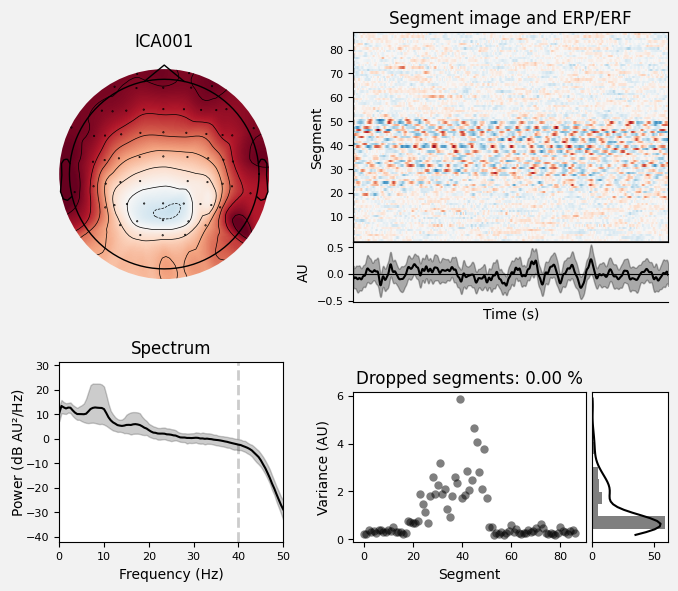

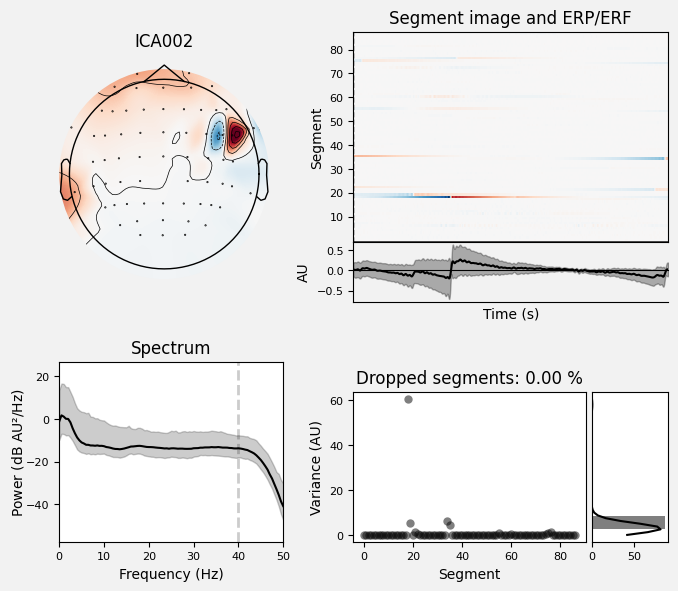

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [ ]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
# pick some random components, see https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#tut-artifact-ica for how to really
# choose the best components to exclude for our data when applying ICA
ica.exclude = [1, 2]
ica.plot_properties(raw, picks=ica.exclude)

# New Section

1.


In [ ]:
from scipy.signal import lfilter

def moving_average_filter(data, window_size=100):
    b = [1.0 / window_size] * window_size
    a = 1
    return lfilter(b, a, data)

for i in range(saved_eeg_data.shape[0]):
    saved_eeg_data[i, :] = moving_average_filter(saved_eeg_data[i, :], window_size=500)


NameError: name 'saved_eeg_data' is not defined

2.

In [ ]:
from scipy.signal import firwin, filtfilt

def bandpass_filter(data, lowcut=1, highcut=30, fs=500, order=100):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b = firwin(order + 1, [low, high], pass_zero=False)
    return filtfilt(b, [1.0], data)

for i in range(saved_eeg_data.shape[0]):
    saved_eeg_data[i, :] = bandpass_filter(saved_eeg_data[i, :])

3.

In [ ]:
from scipy.signal import hamming

def segment_data(data, window_size=1500, overlap=0.9, fs=500):
    step_size = int(window_size * (1 - overlap))
    segments = []
    for start in range(0, data.shape[1] - window_size + 1, step_size):
        segment = data[:, start:start + window_size] * hamming(window_size)
        segments.append(segment)
    return np.array(segments)

segmented_data = segment_data(saved_eeg_data)

4.

In [ ]:
#4
from spectrum import aryule, arma2psd
import numpy as np

def estimate_tremor(window, fs=100, low_freq=3, high_freq=8, ar_order=6):
    # Berg's method
    ar_coeffs, _, _ = aryule(window, ar_order)

    #Compute the power spectral density (PSD) from AR coefficients
    psd = arma2psd(ar_coeffs, sides='centerdc')

    # Convert PSD to frequencies
    freq_bins = np.fft.fftfreq(len(psd), d=1/fs)  # Generate frequency bins
    psd = np.abs(psd)  # Ensure PSD values are positive

    # Select frequencies in the range (3–8 Hz)
    tremor_indices = np.where((freq_bins >= low_freq) & (freq_bins <= high_freq))[0]
    freqs = freq_bins[tremor_indices]
    psd_tremor = psd[tremor_indices]

    return freqs, psd_tremor
